# Demo for nonlinear inverse design of kirigami patterns

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Structure import *
from Utils import *
import scipy.optimize as scopt
import time

## Define an objective function based on circularity

In [2]:
def boundary_residual_circle(interior_offsets_vector):
    
    global width 
    global height
    global target_phi
    global structure
    global boundary_points
    global corners
    global boundary_offsets
    global dual_bound_inds
    global reduced_dual_bound_inds
    global boundary_points_vector
    
    interior_offsets = np.reshape(interior_offsets_vector, (height, width))
    
    # update the pattern using the linear inverse design method with the input offset
    structure.linear_inverse_design(boundary_points_vector, corners, interior_offsets, boundary_offsets)
    structure.make_hinge_contact_points()

    # get the second contracted state
    deployed_points, deployed_hinge_contact_points = structure.layout(phi=0.0) 
    
    # assess the circularity using sum( (r-r_mean)^2 )
    distance_from_center = np.sqrt(np.square(np.array(deployed_points[reduced_dual_bound_inds,0]-np.mean(deployed_points[reduced_dual_bound_inds,0]))) + np.square(np.array(deployed_points[reduced_dual_bound_inds,1]-np.mean(deployed_points[reduced_dual_bound_inds,1]))))
    residuals = distance_from_center - np.mean(distance_from_center)
    
    # (Alternative way) assess the circularity using (L^2/(4*pi*A) - 1)^2
    # reduced_dual_bound_inds_shifted = reduced_dual_bound_inds[1:]
    # reduced_dual_bound_inds_shifted.append(reduced_dual_bound_inds[0])
    # edgelengths = np.sqrt(np.square(np.array(deployed_points[reduced_dual_bound_inds,0]-deployed_points[reduced_dual_bound_inds_shifted,0])) + np.square(np.array(deployed_points[reduced_dual_bound_inds,1]-deployed_points[reduced_dual_bound_inds_shifted,1])))
    # L = np.sum(edgelengths)
    # pgon = geom.Polygon(zip(deployed_points[reduced_dual_bound_inds,0], deployed_points[reduced_dual_bound_inds,1]))
    # A = pgon.area
    # residuals = L**2/(4*np.pi*A) - 1
    
    return residuals

## Solve for an optimized pattern that gives a square-to-circle transformation

In [3]:
# set the pattern size
width = 4 
height = 4

# create a square kirigami structure and get the required information for the optimization
structure = MatrixStructure(num_linkage_rows=height, num_linkage_cols=width)
bound_linkage_inds = [structure.get_boundary_linkages(i) for i in range(4)]
bound_directions = np.array([[-1.0, 0.0], [0.0, -1.0], [1.0, 0.0], [0.0, 1.0]])
boundary_points = []
corners = []
for i, bound in enumerate(bound_linkage_inds):
    local_boundary_points = []
    for j, linkage_ind in enumerate(bound):
        p = structure.is_linkage_parallel_to_boundary(linkage_ind[0], linkage_ind[1], i)
        if j == 0:
            corner = np.array([linkage_ind[1], -linkage_ind[0]]) + bound_directions[i]
            if not p:
                corner += bound_directions[(i-1)%4]
            corners.append(corner)
        if not p:
            point = np.array([linkage_ind[1], -linkage_ind[0]]) + bound_directions[i]
            local_boundary_points.append(point)
    boundary_points.append(np.vstack(local_boundary_points))
corners = np.vstack(corners)
boundary_offsets = [[0.0]*height, [0.0]*width, [0.0]*height, [0.0]*width]
boundary_points_vector = np.vstack(boundary_points)

# also get the reconfigured boundary node indices for optimizing the second contracted shape
structure.linear_inverse_design(boundary_points_vector, corners, np.reshape(np.zeros(width*height), (height, width)), boundary_offsets)
structure.make_hinge_contact_points()
deployed_points, deployed_hinge_contact_points = structure.layout(phi=0.0) 
dual_bound_inds = []
for bound_ind in range(4):
    dual_bound_inds.extend(structure.get_dual_boundary_node_inds(bound_ind))
reduced_dual_bound_inds = []
for i, ind in enumerate(dual_bound_inds):    
    next_i = (i+1) % len(dual_bound_inds)    
    next_ind = dual_bound_inds[next_i]    
    if norm(deployed_points[ind] - deployed_points[next_ind]) > 1e-10:
        reduced_dual_bound_inds.append(ind)
        
# perform the nonlinear optimization to find an optimal set of offset parameters 
# that gives a square-to-circle transformation
print("Optimization starts...")
start = time.time()
result = scopt.least_squares(boundary_residual_circle, np.zeros(width*height),bounds=(-np.ones(width*height),np.inf),xtol = 1e-4,verbose=2)
end = time.time()
print("Finished.")
print('Time taken = ' + str(end - start) + ' seconds')
print('Cost = ' + str(result.cost))
print('Optimal offset = ')
print(result.x)

Optimization starts...
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2997e+00                                    3.83e-01    
       1              2         6.5973e-01      6.40e-01       1.00e+00       1.83e-01    
       2              4         4.5682e-01      2.03e-01       4.73e-01       1.22e-01    
       3              5         2.4283e-01      2.14e-01       9.58e-01       9.59e-02    
       4              7         1.7354e-01      6.93e-02       4.89e-01       5.12e-02    
       5              8         1.0945e-01      6.41e-02       9.99e-01       2.02e-01    
       6              9         8.6549e-02      2.29e-02       2.00e+00       3.12e-01    
       7             10         4.6675e-02      3.99e-02       2.00e+00       1.62e-01    
       8             12         4.1710e-02      4.97e-03       6.65e-01       1.14e-02    
       9             13         4.1333e-02      3.77e-04       1.33

## Plot the optimized pattern

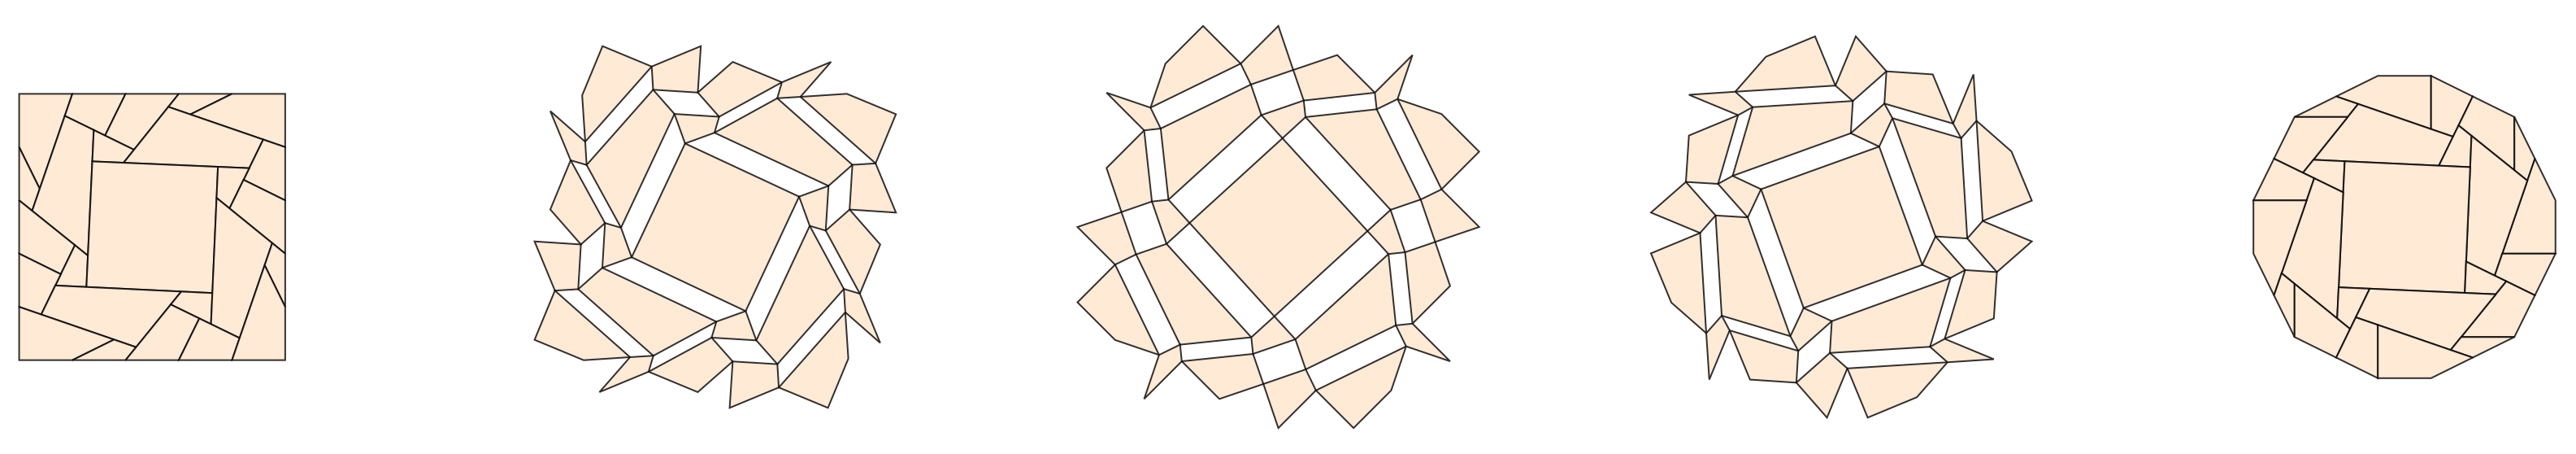

In [4]:
interior_offsets = np.reshape(result.x, (height,width)) # optimal offsets
structure.linear_inverse_design(np.vstack(boundary_points), corners, interior_offsets, boundary_offsets)
structure.assign_node_layers()
structure.assign_quad_genders()
structure.make_hinge_contact_points()

num_frames = 5
phis = np.linspace(np.pi, 0, num_frames)

panel_size = 10
fig, axs = plt.subplots(1, num_frames, figsize=(1.2*panel_size*num_frames, panel_size), sharey=True)

for ax_ind, phi in enumerate(phis):
    
    deployed_points, deployed_hinge_contact_points = structure.layout(phi)
    deployed_points = rotate_points(deployed_points, np.array([0, 0]), -(np.pi - phi)/2.0)
    
    deployed_points[:,0] = deployed_points[:,0] - (np.max(deployed_points[:,0])+np.min(deployed_points[:,0]))/2
    deployed_points[:,1] = deployed_points[:,1] - (np.max(deployed_points[:,1])+np.min(deployed_points[:,1]))/2
    
    plot_structure(deployed_points, structure.quads, structure.linkages, axs[ax_ind])
    axs[ax_ind].set_aspect('equal')
    
#     write_obj('Example_square-to-circle_' + str(ax_ind) + '.obj', deployed_points, structure.quads)